# 🧬 Week 2 — Data Acquisition & Preprocessing

**Dataset:** GSE112509  
**Goal:** Load raw counts + metadata, clean, filter, normalise, and prepare data for Week 3 (PCA & clustering).

This notebook covers:
1. Downloading/Loading raw counts  
2. Loading metadata  
3. Quality checks  
4. Filtering low-expression genes  
5. Normalisation (Log + DESeq2 VST)  
6. Saving Week 2 deliverables  


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)

# Load raw counts file
raw_counts_path = "data/raw/GSE112509_raw_counts_GRCh38.p13_NCBI.tsv.gz"
raw = pd.read_csv(raw_counts_path, sep="\t", index_col=0)

raw.head()

,GSM3071633,GSM3071634,GSM3071635,GSM3071636,GSM3071637,GSM3071638,GSM3071639,GSM3071640,GSM3071641,GSM3071642,GSM3071643,GSM3071644,GSM3071645,GSM3071646,GSM3071647,GSM3071648,GSM3071649,GSM3071650,GSM3071651,GSM3071652,GSM3071653,GSM3071654,GSM3071655,GSM3071656,GSM3071657,...,GSM3071687,GSM3071688,GSM3071689,GSM3071690,GSM3071692,GSM3071693,GSM3071694,GSM3071695,GSM3071696,GSM3071697,GSM3071698,GSM3071699,GSM3071700,GSM3071701,GSM3071702,GSM3071703,GSM3071704,GSM3071705,GSM3071706,GSM3071707,GSM3071708,GSM3071709,GSM3071710,GSM3071711,GSM3071712
GeneID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100287102,5,6,10,16,9,2,12,8,17,13,13,13,11,46,13,20,3,10,3,11,5,12,75,17,28,...,15,33,36,6,7,7,53,14,10,11,50,7,9,3,10,21,14,10,12,9,11,7,19,5,11
653635,1237,575,1588,813,955,1133,1696,988,1975,1207,1456,1896,1229,2362,1024,1733,412,820,488,1015,981,961,6098,1745,2850,...,1342,1132,2148,1643,1029,1132,1313,1282,1209,3001,4601,1513,1997,718,491,1583,1486,839,1069,992,820,782,2789,607,727
102466751,22,5,44,18,31,38,60,57,91,53,20,78,25,96,36,66,8,27,18,54,57,31,244,68,102,...,64,28,57,55,48,30,49,52,31,96,206,37,68,16,7,47,47,31,15,46,30,27,81,14,20
107985730,3,0,1,1,1,3,2,1,2,0,0,1,1,2,2,1,0,1,0,1,6,1,9,4,4,...,3,0,7,0,1,1,2,3,0,3,0,2,0,1,1,1,3,2,4,3,0,3,13,3,1
100302278,0,0,0,1,3,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,10,3,2,...,0,12,4,0,0,1,0,1,2,1,1,2,0,0,0,2,1,1,2,1,0,0,3,1,0


In [16]:
raw.describe()
print("Raw count matrix shape:", raw.shape)

Raw count matrix shape: (39376, 79)


In [17]:
raw.isnull().sum().sum()

np.int64(0)

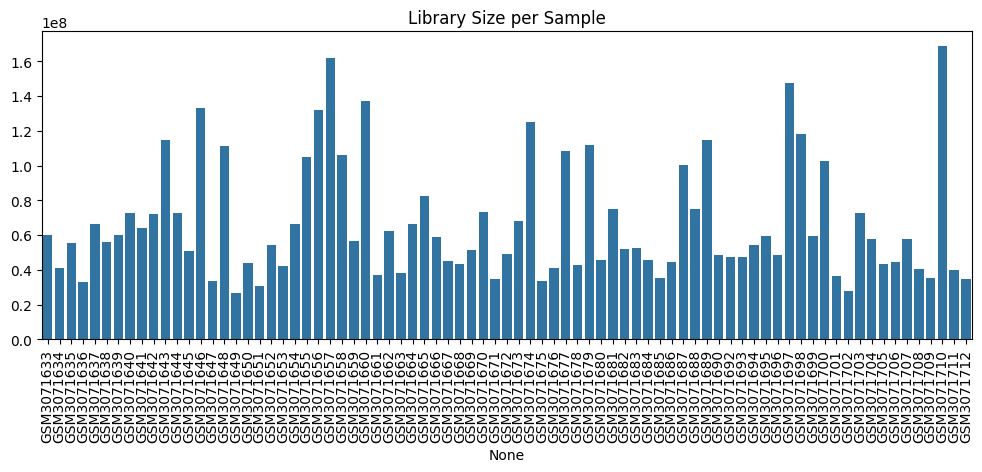

In [8]:
library_sizes = raw.sum(axis=0)

plt.figure(figsize=(12,4))
sns.barplot(x=library_sizes.index, y=library_sizes.values)
plt.xticks(rotation=90)
plt.title("Library Size per Sample")
plt.show()

In [9]:
meta_path = "data/raw/GSE112509_series_matrix.txt.gz"

meta = pd.read_csv(
    meta_path,
    sep="\t",
    comment="!",
    header=None
)

meta.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
0,ID_REF,GSM3071633,GSM3071634,GSM3071635,GSM3071636,GSM3071637,GSM3071638,GSM3071639,GSM3071640,GSM3071641,GSM3071642,GSM3071643,GSM3071644,GSM3071645,GSM3071646,GSM3071647,GSM3071648,GSM3071649,GSM3071650,GSM3071651,GSM3071652,GSM3071653,GSM3071654,GSM3071655,GSM3071656,...,GSM3071688,GSM3071689,GSM3071690,GSM3071691,GSM3071692,GSM3071693,GSM3071694,GSM3071695,GSM3071696,GSM3071697,GSM3071698,GSM3071699,GSM3071700,GSM3071701,GSM3071702,GSM3071703,GSM3071704,GSM3071705,GSM3071706,GSM3071707,GSM3071708,GSM3071709,GSM3071710,GSM3071711,GSM3071712


In [22]:
import gzip

meta_path = "data/raw/GSE112509_series_matrix.txt.gz"

meta_rows = {}

with gzip.open(meta_path, "rt", encoding="utf-8", errors="ignore") as f:
    for line in f:
        if line.startswith("!Sample_characteristics_ch1"):
            parts = line.strip().split("\t")
            values = [p.replace('"', '') for p in parts[1:]]

            # Extract key (e.g. tissue, group, braf mutation)
            key = values[0].split(":")[0]

            # Extract value AFTER colon
            clean_values = [v.split(": ", 1)[1] for v in values]

            # 🔑 FORCE length match with expression matrix
            clean_values = clean_values[:len(raw.columns)]

            meta_rows[key] = clean_values

# Build metadata dataframe
meta_df = pd.DataFrame(meta_rows, index=raw.columns)

meta_df.head()



,tissue,group,nevus type,braf mutation,nras mutation
GSM3071633,benign melanocytic nevi,Naevi_1,dermal,mut,wt
GSM3071634,benign melanocytic nevi,Naevi_1,dermal,mut,mut
GSM3071635,benign melanocytic nevi,Naevi_1,compound,mut,wt
GSM3071636,benign melanocytic nevi,Naevi_1,dermal,wt,mut
GSM3071637,benign melanocytic nevi,Naevi_1,dermal,mut,wt


In [23]:
meta_df["condition"] = meta_df["tissue"].map({
    "benign melanocytic nevi": "Benign",
    "primary melanoma": "Melanoma"
})

meta_df["condition"].value_counts()


condition
Melanoma    56
Benign      23
Name: count, dtype: int64

In [25]:
meta_df.to_csv("data/processed/GSE112509_metadata.csv")

In [26]:
# Keep genes with at least 10 counts in ≥ 3 samples
filtered = raw[raw.ge(10).sum(axis=1) >= 3]

print("Before filtering:", raw.shape)
print("After filtering:", filtered.shape)


Before filtering: (39376, 79)
After filtering: (29830, 79)


In [27]:
log_norm = np.log2(filtered + 1)
log_norm.head()


,GSM3071633,GSM3071634,GSM3071635,GSM3071636,GSM3071637,GSM3071638,GSM3071639,GSM3071640,GSM3071641,GSM3071642,GSM3071643,GSM3071644,GSM3071645,GSM3071646,GSM3071647,GSM3071648,GSM3071649,GSM3071650,GSM3071651,GSM3071652,GSM3071653,GSM3071654,GSM3071655,GSM3071656,GSM3071657,...,GSM3071687,GSM3071688,GSM3071689,GSM3071690,GSM3071692,GSM3071693,GSM3071694,GSM3071695,GSM3071696,GSM3071697,GSM3071698,GSM3071699,GSM3071700,GSM3071701,GSM3071702,GSM3071703,GSM3071704,GSM3071705,GSM3071706,GSM3071707,GSM3071708,GSM3071709,GSM3071710,GSM3071711,GSM3071712
GeneID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100287102,2.584963,2.807355,3.459432,4.087463,3.321928,1.584963,3.700440,3.169925,4.169925,3.807355,3.807355,3.807355,3.584963,5.554589,3.807355,4.392317,2.000000,3.459432,2.000000,3.584963,2.584963,3.700440,6.247928,4.169925,4.857981,...,4.000000,5.087463,5.209453,2.807355,3.000000,3.000000,5.754888,3.906891,3.459432,3.584963,5.672425,3.000000,3.321928,2.000000,3.459432,4.459432,3.906891,3.459432,3.700440,3.321928,3.584963,3.000000,4.321928,2.584963,3.584963
653635,10.273796,9.169925,10.633903,9.668885,9.900867,10.147205,10.728771,9.949827,10.948367,10.238405,10.508785,10.889504,10.264443,11.206404,10.001408,10.759888,8.689998,9.681238,8.933691,9.988685,9.939579,9.909893,12.574357,10.769838,11.477252,...,10.391244,10.145932,11.069450,10.682995,10.008429,10.145932,10.359750,10.325305,10.240791,11.551708,12.168045,10.564149,10.964341,9.489848,8.942515,10.629357,10.538189,9.714246,10.063395,9.955650,9.681238,9.612868,11.446049,9.247928,9.507795
102466751,4.523562,2.584963,5.491853,4.247928,5.000000,5.285402,5.930737,5.857981,6.523562,5.754888,4.392317,6.303781,4.700440,6.599913,5.209453,6.066089,3.169925,4.807355,4.247928,5.781360,5.857981,5.000000,7.936638,6.108524,6.686501,...,6.022368,4.857981,5.857981,5.807355,5.614710,4.954196,5.643856,5.727920,5.000000,6.599913,7.693487,5.247928,6.108524,4.087463,3.000000,5.584963,5.584963,5.000000,4.000000,5.554589,4.954196,4.807355,6.357552,3.906891,4.392317
107985730,2.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.584963,1.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.584963,1.584963,1.000000,0.000000,1.000000,0.000000,1.000000,2.807355,1.000000,3.321928,2.321928,2.321928,...,2.000000,0.000000,3.000000,0.000000,1.000000,1.000000,1.584963,2.000000,0.000000,2.000000,0.000000,1.584963,0.000000,1.000000,1.000000,1.000000,2.000000,1.584963,2.321928,2.000000,0.000000,2.000000,3.807355,2.000000,1.000000
645520,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.321928,1.000000,0.000000,0.000000,2.584963,0.000000,1.584963,2.807355,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.584963,1.584963,2.321928,2.321928,1.584963,...,4.857981,3.700440,0.000000,1.000000,0.000000,1.584963,0.000000,1.000000,0.000000,1.000000,3.700440,2.321928,3.584963,0.000000,0.000000,1.000000,1.584963,0.000000,2.321928,0.000000,0.000000,0.000000,0.000000,1.584963,0.000000


In [28]:
filtered.to_csv("data/processed/GSE112509_filtered_counts.csv")
log_norm.to_csv("data/processed/GSE112509_log_normalized.csv")

print("Filtered and log-normalised matrices saved.")


Filtered and log-normalised matrices saved.
